In [38]:
import datetime
import math
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from models.univariate_local import SarimaForecasting
from models.utils import create_simulated_y

"""
Use:
N_FORECASTING = 4, STEP_SIZE = 12, INTERSECT_FORECASTING = False
N_FORECASTING = 6, STEP_SIZE = 3, INTERSECT_FORECASTING = False
N_FORECASTING = 6, STEP_SIZE = 3, INTERSECT_FORECASTING = True
N_FORECASTING = 6, STEP_SIZE = 1, INTERSECT_FORECASTING = False

For each, run the entire notebook
"""

PLOT_HEIGHT = 4
PLOT_WIDTH = 6
N_FORECASTING = 6
STEP_SIZE = 3
INTERSECT_FORECASTING = False
TRAINING_SIZE_IN_PLOT = 20
TRAINING_COLOR = "blue"
FORECASTING_COLOR = "red"
PREDICTION_COLOR = "green"

In [39]:
y = create_simulated_y(
    freq="ME",
    n_periods=500,
    std=0.2,
    start=datetime.date.today() - datetime.timedelta(days=500 * 30),
)
y = y + 0.1 * y.shift(1)
y = y + 0.05 * y.shift(2)
y = y + 0.3 * y.shift(12)

model = SarimaForecasting(
    y,
    # filter_start_date="2021-01-01",
    n_forecasting=N_FORECASTING,
    rolling=False,
    step_size=STEP_SIZE,
    intersect_forecasting=INTERSECT_FORECASTING,
    only_consider_last_of_each_intersection=INTERSECT_FORECASTING,
    max_p=1,
    max_q=1,
    max_d=0,
    max_seasonal_p=1,
    max_seasonal_q=1,
    max_seasonal_d=0,
)
model.build_divisions()
model.run()
model.assess_error()

In [40]:
PRINT_SEPARATELY = False
xlim_start = model.divisions[0]["training"].y.index[-TRAINING_SIZE_IN_PLOT]
xlim_end = model.divisions[N_FORECASTING - 1]["forecasting"].y_pred.index[-1]

if PRINT_SEPARATELY:
    for i in range(N_FORECASTING):
        y_training = model.divisions[i]["training"].y
        y_forecasting = pd.concat(
            [
                pd.DataFrame(
                    y_training.iloc[-1, 0],
                    index=[y_training.index[-1]],
                    columns=[y_training.columns[0]],
                ),
                model.divisions[i]["forecasting"].y,
            ]
        )
        y_pred = pd.concat(
            [
                pd.DataFrame(
                    y_training.iloc[-1, 0],
                    index=[y_training.index[-1]],
                    columns=[y_training.columns[0]],
                ),
                model.divisions[i]["forecasting"].y_pred.rename(
                    {"forecast": "y"}, axis=1
                ),
            ]
        )
        plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        plt.plot(
            y_forecasting.index,
            y_forecasting.iloc[:, 0],
            linestyle="-",
            marker="o",
            color=FORECASTING_COLOR,
        )
        plt.plot(
            y_pred.index,
            y_pred.iloc[:, 0],
            linestyle="--",
            marker="o",
            color=PREDICTION_COLOR,
        )
        xlim_start = (
            y_training.iloc[-TRAINING_SIZE_IN_PLOT:].index[0]
            if xlim_start is None
            else xlim_start
        )
        plt.plot(
            y_training.loc[xlim_start:].index,
            y_training.loc[xlim_start:].iloc[:, 0],
            linestyle="-",
            marker="o",
            color=TRAINING_COLOR,
        )
        plt.xticks(rotation=45)
        plt.title(f"Forecasting Nº{i + 1}")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend(["Testing", "Prediction", "Training"])
        plt.axvspan(
            y_training.loc[xlim_start:].index[0],
            y_training.loc[xlim_start:].index[-1],
            color=TRAINING_COLOR,
            alpha=0.1,
        )
        plt.axvspan(
            y_training.loc[xlim_start:].index[-1],
            y_pred.index[-1],
            color=PREDICTION_COLOR,
            alpha=0.1,
        )
        plt.xlim(
            [
                xlim_start - datetime.timedelta(days=30),
                xlim_end + datetime.timedelta(days=30),
            ]
        )
        plt.show()

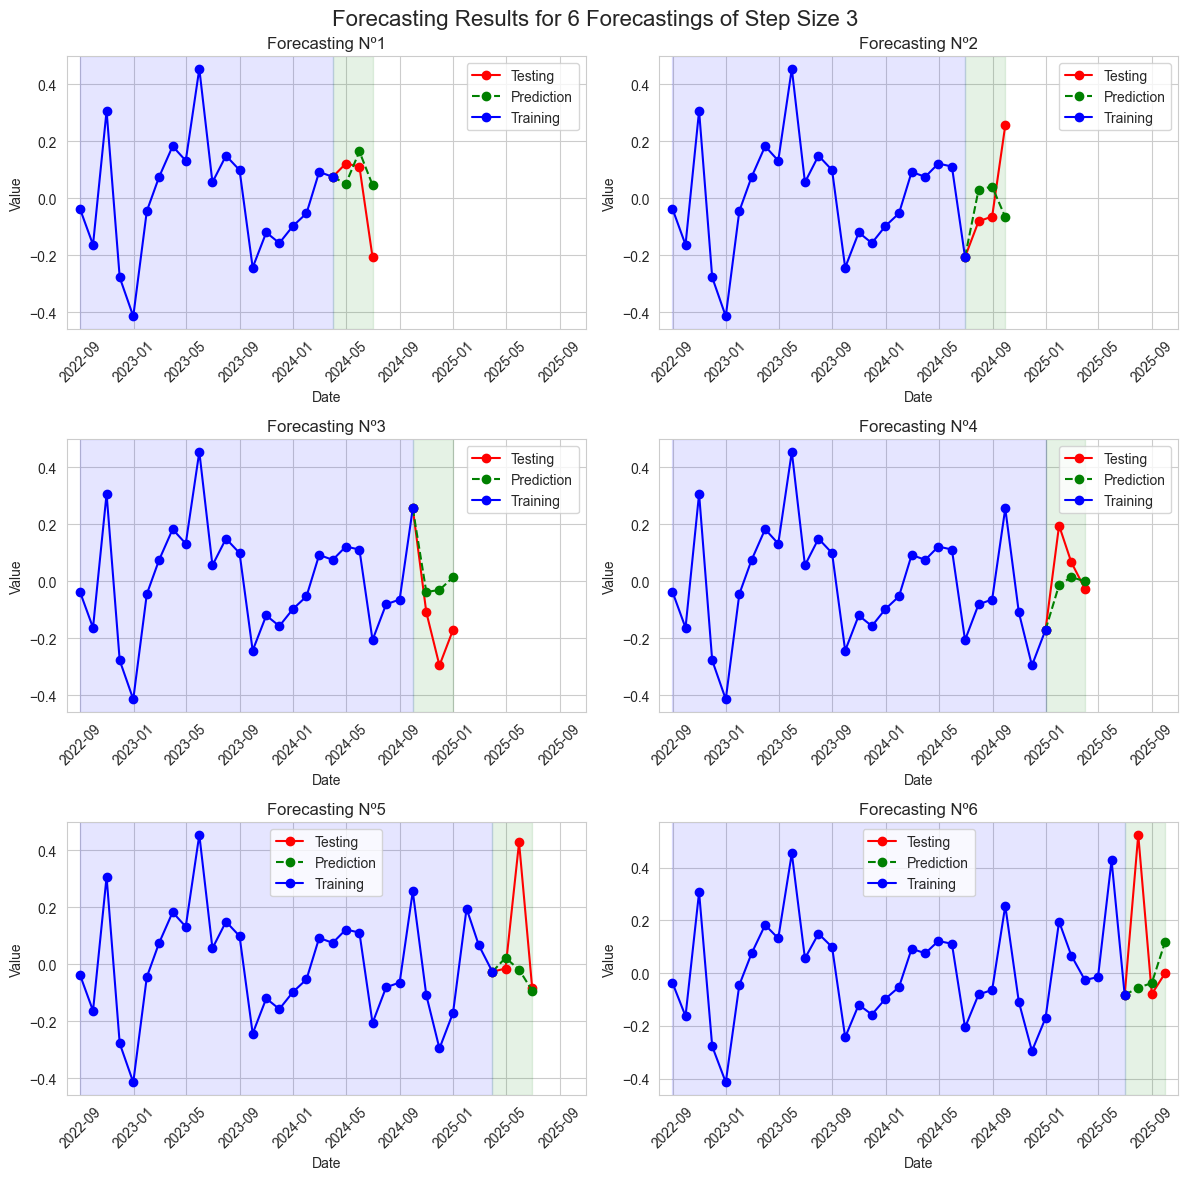

In [41]:
nrows = math.ceil(N_FORECASTING / 2)
fig, axes = plt.subplots(
    nrows=nrows, ncols=2, figsize=(PLOT_WIDTH * 2, PLOT_HEIGHT * nrows)
)
axes = axes.flatten()

for i in range(N_FORECASTING):
    ax = axes[i]
    y_training = model.divisions[i]["training"].y
    y_forecasting = pd.concat(
        [
            pd.DataFrame(
                y_training.iloc[-1, 0],
                index=[y_training.index[-1]],
                columns=[y_training.columns[0]],
            ),
            model.divisions[i]["forecasting"].y,
        ]
    )
    y_pred = pd.concat(
        [
            pd.DataFrame(
                y_training.iloc[-1, 0],
                index=[y_training.index[-1]],
                columns=[y_training.columns[0]],
            ),
            model.divisions[i]["forecasting"].y_pred.rename({"forecast": "y"}, axis=1),
        ]
    )

    current_xlim_start = (
        y_training.iloc[-TRAINING_SIZE_IN_PLOT:].index[0]
        if xlim_start is None
        else xlim_start
    )

    ax.plot(
        y_forecasting.index,
        y_forecasting.iloc[:, 0],
        linestyle="-",
        marker="o",
        color=FORECASTING_COLOR,
    )
    ax.plot(
        y_pred.index,
        y_pred.iloc[:, 0],
        linestyle="--",
        marker="o",
        color=PREDICTION_COLOR,
    )
    ax.plot(
        y_training.loc[current_xlim_start:].index,
        y_training.loc[current_xlim_start:].iloc[:, 0],
        linestyle="-",
        marker="o",
        color=TRAINING_COLOR,
    )
    for label in ax.get_xticklabels():
        label.set_rotation(45)

    ax.set_title(f"Forecasting Nº{i + 1}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.legend(["Testing", "Prediction", "Training"])
    ax.axvspan(
        y_training.loc[current_xlim_start:].index[0],
        y_training.loc[current_xlim_start:].index[-1],
        color=TRAINING_COLOR,
        alpha=0.1,
    )
    ax.axvspan(
        y_training.loc[current_xlim_start:].index[-1],
        y_pred.index[-1],
        color=PREDICTION_COLOR,
        alpha=0.1,
    )
    ax.set_xlim(
        [
            current_xlim_start - datetime.timedelta(days=30),
            xlim_end + datetime.timedelta(days=30),
        ]
    )

for j in range(N_FORECASTING, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout(rect=[0, 0, 1, 0.97])

int_forecasting = " Intersecting Forecasting" if INTERSECT_FORECASTING else ""
fig.suptitle(
    f"Forecasting Results for {N_FORECASTING:.0f} Forecastings of Step Size {STEP_SIZE:.0f}{int_forecasting}",
    fontsize=16,
)
image_name = f"forecasting_example_nf{N_FORECASTING:.0f}_step{STEP_SIZE:.0f}"
image_name += "_intersect" if INTERSECT_FORECASTING else ""
if not os.path.exists("../report/images/forecasting_explanation"):
    os.makedirs("../report/images/forecasting_explanation")
fig.savefig(f"../report/images/forecasting_explanation/{image_name}.png")
plt.show()